In [2]:
import cv2
import torch
import sys
from paddleocr import PaddleOCR
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import pytesseract
from PIL import Image
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Для Windows


reader = easyocr.Reader(
    lang_list=['ru', 'en'],
    gpu=True,          # Важно!
    model_storage_directory='model_folder',
    download_enabled=True
)

def eocr1(img):
    result = reader.readtext(img, detail=0)
    return result
    
def img_plot(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Инициализация (используем только детектор DBnet)
ocr = PaddleOCR(
    det_model_dir='en+rus_PP-OCRv4_det',  # Версия с DBnet
    rec_model_dir='en+rus_PP-OCRv4_rec', 
    use_gpu=True,
    rec=False
)

def super_resolution(image, scale=3):
        height, width = image.shape[:2]
        return cv2.resize(image, (width*scale, height*scale), 
                        interpolation=cv2.INTER_CUBIC)

def remove_background(region):
    gray = cv2.cvtColor(region, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def text_detection(img_path, preview = False):
    result = ocr.ocr(img_path, cls=False)
    img_rect = cv2.imread(img_path)

    # Список для хранения вырезанных областей
    cropped_regions = []

    # Добавляем параметр delta в начало скрипта
    delta = 5  # Количество пикселей для расширения области (можно настроить)

    # Обработка каждой обнаруженной области
    for i, det in enumerate(result[0]):
        points = np.array(det[0], dtype=np.int32)

        # Находим границы области с учетом delta
        x, y, w, h = cv2.boundingRect(points)
        
        # Корректируем координаты с учетом delta, не выходя за границы изображения
        x1 = max(0, x - delta)
        y1 = max(0, y - delta)
        x2 = min(img_rect.shape[1], x + w + delta)  # shape[1] - ширина изображения
        y2 = min(img_rect.shape[0], y + h + delta)  # shape[0] - высота изображения

        # Вырезаем расширенную область напрямую из изображения (без маски)
        region = img_rect[y1:y2, x1:x2].copy()  # .copy() чтобы избежать проблем с памятью
        
        # Конвертируем в RGB и добавляем в список
        region_rgb = cv2.cvtColor(region, cv2.COLOR_BGR2RGB)
        cropped_regions.append(region_rgb)

        # Отрисовка оригинальных границ (без delta)
        cv2.polylines(img_rect, [points], isClosed=True, color=(0, 255, 0), thickness=2)
        
    img_rgb = cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB)  
    img_plot(img_rgb)

    text_on_image = []
    for region in cropped_regions:
        clean_region = remove_background(region)
        sup_res = super_resolution(clean_region)
        # Распознаем текст с помощью EasyOCR
        rec_txt_eocr = eocr1(sup_res)
        if preview:
            img_plot(sup_res)
            print(rec_txt_eocr)
        text_on_image.append(" ".join(rec_txt_eocr))
        
    result = " ".join(text_on_image)
    return result

[2025/05/03 12:42:15] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='en+rus_PP-OCRv4_det', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='en+rus_PP-OCRv4_rec', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='C:\\Users\\vadim\\AppData\\Roa

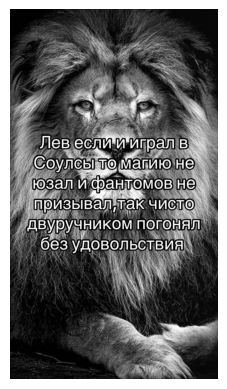

[2025/05/03 13:01:47] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.3691704273223877
[2025/05/03 13:01:47] ppocr DEBUG: rec_res num  : 6, elapsed : 0.24556660652160645


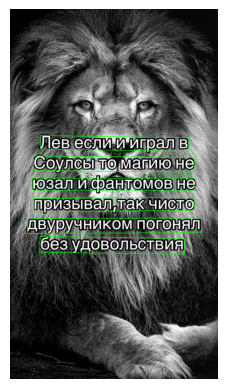

Левесли МиБрале оулсытоммапик Hr Юзал ифанломовше 4 Г . призывалнак чисшс 0 inn; 7 1 иhM двуручником погоня) V } без удовольствия й ', {м 1 , V1 KON]


In [13]:
# import time
# elpsd_times = []
# for i in range(92):
#     start_time = time.perf_counter()

#     path = 'tst/' + str(i+1) + '.jpg'
#     txt = text_detection(path, preview = True)
#     print(txt)
#     elapsed_time = time.perf_counter() - start_time
#     elpsd_times.append(elapsed_time)
#     print('Time spent', elapsed_time)
path = 'tst/93.jpg'
img_plot(Image.open(path))
print(text_detection(path))